# Relationship between num_modes and error for real complementary polynomials.

This notebook investigates how the error of the fft_complementary_polynomial method changes based on the input parameters. This is used to explain how the default settings for the method were determined.

In [1]:

import numpy as np
import pytest

from qualtran.bloqs.for_testing.matrix_gate import MatrixGate

from qualtran.bloqs.qsp.fft_qsp import fft_complementary_polynomial
from qualtran.bloqs.qsp.generalized_qsp_test import verify_generalized_qsp
from qualtran.linalg.polynomial.qsp_testing import random_qsp_polynomial
from numpy.polynomial import Polynomial
from typing import Iterable, Iterator, Sequence, Set, Tuple, TYPE_CHECKING, Union
from qualtran.symbolics import Shaped

import matplotlib.pyplot as plt

def check_gqsp_polynomial_pair_on_random_points_on_unit_circle(
    P: Union[Sequence[complex], Polynomial, Shaped],
    Q: Union[Sequence[complex], Polynomial, Shaped],
    *,
    random_state: np.random.RandomState,
    n_points: int = 1000,
):

    P = Polynomial(P)
    Q = Polynomial(Q)

    z = np.exp(random_state.random(size=n_points) * np.pi * 2j)
    unity = np.abs(P(z)) ** 2 + np.abs(Q(z)) ** 2
    return max(abs(1-unity))

def complimentary_polynomial_with_check(
    degree: int,  min_modes: int, only_real_coeffs:bool
):
    random_state = np.random.RandomState(42)
    tolerance = 1e-9
    P = random_qsp_polynomial(degree, random_state=random_state, only_real_coeffs=only_real_coeffs)
    Q = fft_complementary_polynomial(P, tolerance=tolerance, num_modes=min_modes)
    if only_real_coeffs:
        np.testing.assert_allclose(np.imag(Q), 0, atol=tolerance)
    return check_gqsp_polynomial_pair_on_random_points_on_unit_circle(
        P, Q, random_state=random_state, n_points=10000
    )



In [2]:
def complimentary_real_polynomial_error_search():
    xyz = []
    for deg in range(3,100):
        for modes in range(100,300): # Experimentally, at least 9 modes are needed to get an error within a "ballpark" tolerance.
            result = complimentary_polynomial_with_check(deg, modes, only_real_coeffs=True)
            xyz.append([deg, modes, result])
    return np.array(xyz)
xyz = complimentary_real_polynomial_error_search()


# How does the degree and num_modes relate to a given error cutoff point?

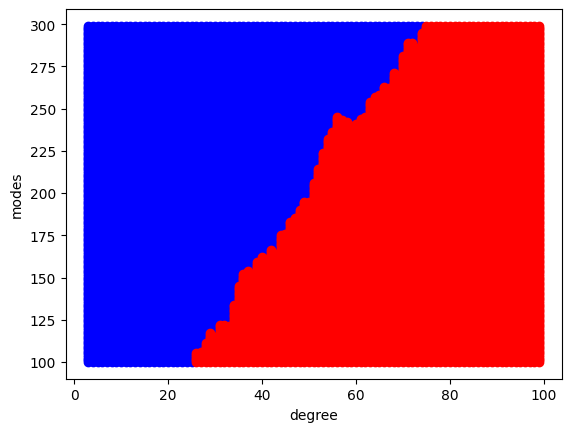

In [3]:
def plot_deg_vs_num_modes(xyz:np.ndarray, tol:float):
    good = np.where(xyz[:,2] < tol)
    bad = np.where(xyz[:,2] >= tol)
    plt.scatter(xyz[good,0], xyz[good,1], c='b')
    plt.scatter(xyz[bad,0], xyz[bad,1], c='r')
    plt.xlabel("degree")
    plt.ylabel("modes")
plot_deg_vs_num_modes(xyz,tol = 1e-9)

The above plot shows that the number of modes needed 

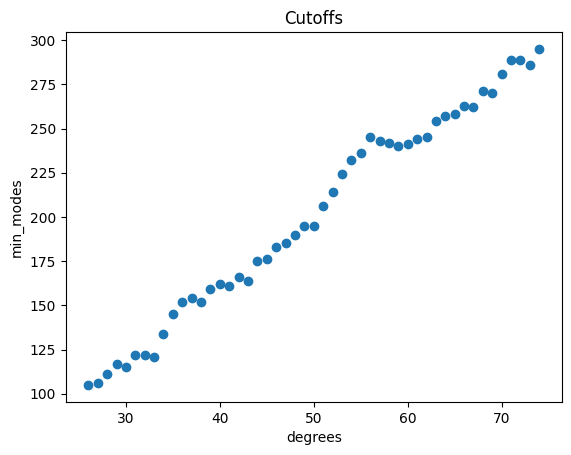

In [4]:
def plot_cutoff(xyz:np.ndarray, tol:float)->np.ndarray:
    results = []
    max_modes_in_dataset = np.max(xyz[:,1])

    for deg in set(xyz[:,0]):
        try:
            points_at_deg = xyz[np.where(xyz[:,0] == deg)]
            bad_points_at_deg = points_at_deg[np.where(points_at_deg[:,2] >= tol)]
            needed_modes = np.max(bad_points_at_deg[:,1])
            # We first make sure that we don't reach the maximum. 
            # We can only see points as high as what is in our dataset xyz.
            # Anything that hits the maximum is considered "off the chart" 
            # and is discarded.
            if needed_modes < max_modes_in_dataset:
                results.append([deg, needed_modes])
        except ValueError:
            continue
    results = np.array(results)
    
    plt.scatter(results[:,0],results[:,1])
    plt.xlabel("degrees")
    plt.ylabel("min_modes")
    plt.title("Cutoffs")
    plt.show()
    return results
cutoffs = plot_cutoff(xyz,tol = 1e-9)


It appears that the leftmost curve (going up to degree 35) remains consistent before noisiness takes over. This curve could likely be used as a conservative estimate for the number of modes needed.

In [5]:
!pip install scikit-learn

In [6]:
from sklearn.metrics import r2_score 
def estimate_boundary(cutoffs:np.ndarray):
    # We take the first 10 datapoints that form the conservative curve.
    x = cutoffs[:,0]
    y = cutoffs[:,1]
    
    # Use linear regression to create a polynomial fit.
    coeffs = np.polyfit(x,y,1)
    poly = Polynomial(np.flip(coeffs))
    print("r2_score",r2_score(y_true=y, y_pred=poly(x)))
    print("poly:",poly)
    return poly
    
poly = estimate_boundary(cutoffs)

r2_score 0.9876950044680343
poly: -1.82142857 + 4.05846939·x


As an estimate, we can calculate the needed minimum num_modes given the degree.

# Here we repeat the above process for complex polynomials

In [ ]:
def complimentary_complex_polynomial_error_search():
    xyz = []
    for deg in range(3,100):
        for modes in range(100,300): # Experimentally, at least 9 modes are needed to get an error within a "ballpark" tolerance.
            result = complimentary_polynomial_with_check(deg, modes, only_real_coeffs=False)
            xyz.append([deg, modes, result])
    return np.array(xyz)
xyz_complex = complimentary_complex_polynomial_error_search()
plot_deg_vs_num_modes(xyz_complex,tol=1e-9)


In [ ]:
cutoffs_complex =  plot_cutoff(xyz_complex,tol = 1e-9)
poly_complex = estimate_boundary(cutoffs_complex)

In [ ]:
poly_complex(100)